In [ ]:
using LinearAlgebra
using Plots

# Basic parameters
# nt = 2000    # Number of time steps
vs = 3000    # Wave velocity [m/s] 
ro0 = 2500    # Density [kg/m^3]
nx = 100    # Number of grid points  
xmax = 10000.0  # Maximum length
t_max = 0.1    # Maximum time
eps = 0.01     # Stability limit
iplot = 1      # Snapshot frequency

dx = xmax / (nx - 1)           # calculate space increment
x = range(0, stop=nx - 1) * dx   # initialize space coordinates
x = transpose(x)
h = diff(vec(x) )                    # calculate the element sizes)

# parameters
ro = x * 0 .+ ro0           # initialize density array
mu = x * 0 .+ ro .* vs .^ 2   # calculate shear modulus from density and velocity

# time step from stability criterion
dt = eps * dx / maximum(sqrt.(mu ./ ro))

nt = round(Int, t_max / dt)   # calculate number of time steps
# println(vs * dt / dx, "  ", nt)

# initialize time axis
t = range(dt, stop=nt * dt, length=nt)

# 
u = ones(nx)
uold = zeros(nx)
unew = zeros(nx)

p = zeros(nx)
pold = zeros(nx)
pnew = zeros(nx)

# Source term (simple Ricker wavelet)
function ricker_wavelet(t, f; tau=2.0)
    wavelet = sin.(2.0 * pi * f * t)
    return wavelet
end

# Mass matrix M_ij
M = zeros(nx, nx)
for i in 2:nx-1
    for j in 2:nx-1
        if j == i
            M[i, j] = (ro[i-1] * h[i-1] + ro[i] * h[i]) / 3
        elseif j == i + 1
            M[i, j] = ro[i] * h[i] / 6
        elseif j == i - 1
            M[i, j] = ro[i-1] * h[i-1] / 6
        else
            M[i, j] = 0
        end
    end
end

# Corner elements
M[1, 1] = ro[1] * h[1] / 3
M[nx, nx] = ro[nx] * h[nx-1] / 3

# Invert M
Minv = inv(M)

# heatmap(Minv, title="Mass Matrix M", color=:viridis, legend=false)

# Stiffness matrix Kij
K = zeros(nx, nx)
for i in 2:nx-1
    for j in 2:nx-1
        if j == i
            K[i, j] = mu[i-1] / h[i-1] + mu[i] / h[i]
        elseif j == i + 1
            K[i, j] = -mu[i] / h[i]
        elseif j == i - 1
            K[i, j] = -mu[i-1] / h[i-1]
        else
            K[i, j] = 0
        end
    end
end

# Corner elements
K[1, 1] = mu[1] / h[1]
K[nx, nx] = mu[nx-1] / h[nx-1]

# heatmap(K, title="Stiffness Matrix K", color=:viridis, legend=false)

u_time = zeros(nt, nx)
for it in 1:nt
    unew = (dt^2) * Minv * (K * u) + 2*u - uold     
    
    # Source term (explosion)
    # unew[round(Int, nx/2)] += ricker_wavelet(t[it], 1.0, tau=0.1)

    uold, u = u, unew

    u_time[it, :] = u
    # if it % 10 == 0
    #     IJulia.clear_output(true)
    #     p = plot(u, legend=false, title="time: $(it*dt) s")
        # plot!(x, p, color=:red, linewidth=1.5)
        # title!("Solution at t = $(it*dt)")
    #     display(p)
    # end

end

max_u = maximum(u_time)
min_u = minimum(u_time)

# println(u_time[nt, :])

# display
for it in 1:nt
#     # if it % iplot == 0
        IJulia.clear_output(true)
        p = plot(u_time[it, :], legend=false, title="time: $(it*dt) s", #= ylims=(min_u, max_u) =#)
#         title!("Solution at t = $(it*dt)")
        display(p)
#     # end
end


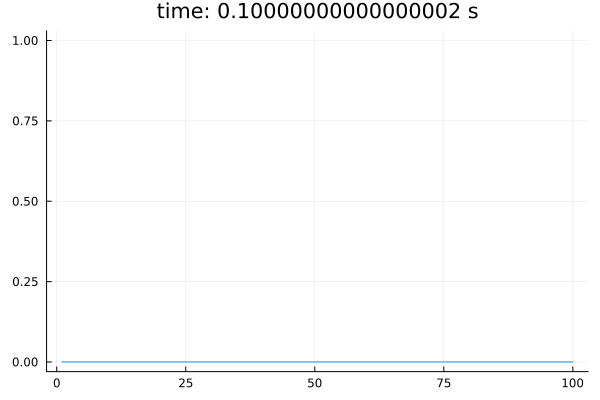

In [1]:
using LinearAlgebra
using Plots

# Basic parameters
vs = 100    # Wave velocity [m/s] 
f = 1.0        # Central frequency of the source (in Hz)
λ = c / f      # Wavelength

ro0 = 1000    # Density [kg/m^3]
nx = 100    # Number of grid points  
xmax = 10.0  # Maximum length
t_max = 0.1    # Maximum time
eps = 0.1     # Stability limit
iplot = 1      # Snapshot frequency

dx = xmax / (nx - 1)           # calculate space increment
println("dx ",dx)
x = range(0, stop=nx - 1) * dx   # initialize space coordinates
x = transpose(x)
h = diff(vec(x))                    # calculate the element sizes)

# parameters
ro = x * 0 .+ ro0          # initialize density array
young_mod = x * 0 .+ ro .* vs .^ 2   # calculate young modulus from density and velocity

# time step from stability criterion
dt = eps * dx / maximum(sqrt.(young_mod ./ ro))
println("dt ",dt)

nt = round(Int, t_max / dt)   # calculate number of time steps
println("nt ",nt)

# initialize time axis
t = range(dt, stop=nt * dt, length=nt)

u = zeros(nx)
uold = zeros(nx)
unew = zeros(nx)

# Source term (simple Ricker wavelet)
function ricker_wavelet(t, f)
    wavelet = sin.(2.0 * pi * f * t)
    return wavelet
end

function linear_basis(xi)
    return [(1 - xi) / 2, (1 + xi) / 2]
end

function jacobian(x1, x2)
    return (x2 - x1) / 2
end

function gauss_legendre_quadrature()
    # Poin dan bobot kuadratur Gauss-Legendre untuk dua poin
    points = [-1 / sqrt(3), 1 / sqrt(3)]
    weights = [1.0, 1.0]

    return points, weights
end

function mass_matrix(x1, x2, rho, A)
    points, weights = gauss_legendre_quadrature()

    M = zeros(2, 2)

    for k in 1:2
        xi = points[k]
        w = weights[k]

        basis_values = linear_basis(xi)

        for i in 1:2
            for j in 1:2
                M[i, j] += w * basis_values[i] * basis_values[j] * rho * A * jacobian(x1, x2)
            end
        end
    end

    return M
end

function stiffness_matrix(x1, x2, ym)
    points, weights = gauss_legendre_quadrature()

    K = zeros(2, 2)

    for k in 1:2
        xi = points[k]
        w = weights[k]

        basis_derivatives = [-1 / 2, 1 / 2] / (x2 - x1)  # Derivatives of linear basis functions

        for i in 1:2
            for j in 1:2
                K[i, j] += w * ym * basis_derivatives[i] * basis_derivatives[j] / jacobian(x1, x2)
            end
        end
    end

    return K
end

# make mass matrix
mass_matrices = zeros(nx, nx)

# Interior elements
for i in 2:nx-1
    mass_matrices[i:i+1, i:i+1] += mass_matrix(x[i-1], x[i], ro[i-1], h[i-1])
end

# Corner elements
mass_matrices[1:2, 1:2] += mass_matrix(x[1], x[2], ro[1], h[1])
mass_matrices[1, 1] += mass_matrix(x[1], x[2], ro[1], h[1])[1, 1]
mass_matrices[nx, nx] += mass_matrix(x[nx-1], x[nx], ro[nx-1], h[nx-1])[2, 2]

# Invert M
mass_matrices_inv = inv(mass_matrices)

# heatmap(mass_matrices_inv, title="Mass Matrix M", color=:viridis, legend=false)


# Make stiffness matrix
stiffness_matrices = zeros(nx, nx)

for i in 2:nx-1
    stiffness_matrices[i:i+1, i:i+1] += stiffness_matrix(x[i-1], x[i], young_mod[i])
end

# Corner elements
stiffness_matrices[1:2, 1:2] += stiffness_matrix(x[1], x[2], young_mod[1])
stiffness_matrices[1, 1] += stiffness_matrix(x[1], x[2], young_mod[1])[1, 1]
stiffness_matrices[nx, nx] += stiffness_matrix(x[nx-1], x[nx], young_mod[nx-1])[2, 2]

# Plot stiffness matrix
# heatmap(stiffness_matrices, title="Stiffness Matrix K", color=:viridis, legend=false)

# do time stepping
u_time = zeros(nt, nx)

for it in 1:nt
    unew = (dt^2) * mass_matrices_inv * (stiffness_matrices * u) + 2*u - uold     
    
    # Source term (explosion)
    unew[round(Int, nx/2)] += ricker_wavelet(t[it], 1.0)

    uold, u = u, unew

    u_time[it, :] = u
    # if it % 10 == 0
    #     IJulia.clear_output(true)
    #     p = plot(u, legend=false, title="time: $(it*dt) s")
        # plot!(x, p, color=:red, linewidth=1.5)
        # title!("Solution at t = $(it*dt)")
    #     display(p)
    # end

end

max_u = maximum(u_time)
min_u = minimum(u_time)

# println(u_time[nt, :])

# display
for it in 1:nt
    #     # if it % iplot == 0
    IJulia.clear_output(true)
    p = plot(u_time[it, :], legend=false, title="time: $(it*dt) s",) #= ylims=(min_u, max_u) =#
    #         title!("Solution at t = $(it*dt)")
    display(p)
    #     # end

    # break if u too large
    if maximum(u_time[it, :]) > 1e10
        break
    end
end
